In [ ]:
from google.colab import files
uploaded = files.upload()  # This will prompt you to upload your dataset.zip file


Saving dataset.zip to dataset.zip


In [ ]:
import zipfile
import os

# Unzip the dataset
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("Dataset extracted!")


Dataset extracted!


In [ ]:
# List extracted folder contents
print("Contents of dataset folder:")
print(os.listdir("dataset"))


Contents of dataset folder:
['ASL-Dataset']


In [ ]:
import pandas as pd
import os
from IPython.display import display


# Load CSV files
test_csv = pd.read_csv("dataset/ASL-Dataset/test/_classes.csv")
train_csv = pd.read_csv("dataset/ASL-Dataset/train/_classes.csv")
valid_csv = pd.read_csv("dataset/ASL-Dataset/valid/_classes.csv")

# Display dataset information
def inspect_dataset(name, df):
    print(f"\n{name} Dataset:\n")
    print(f"Number of samples: {len(df)}")
    #print(f"Columns: {df.columns.tolist()}")
    #print("\nSample rows:\n")
    #display(df.head())

# Inspect train, test, and validation datasets
inspect_dataset("Train", train_csv)
inspect_dataset("Test", test_csv)
inspect_dataset("Validation", valid_csv)

# Check for missing values
def check_missing_values(df, name):
    missing = df.isnull().sum().sum()
    print(f"\n{name} Dataset Missing Values: {missing}")

check_missing_values(train_csv, "Train")
check_missing_values(test_csv, "Test")
check_missing_values(valid_csv, "Validation")



Train Dataset:

Number of samples: 1512

Test Dataset:

Number of samples: 72

Validation Dataset:

Number of samples: 144

Train Dataset Missing Values: 0

Test Dataset Missing Values: 0

Validation Dataset Missing Values: 0


In [ ]:
print(train_csv.columns)

Index(['filename', ' A', ' B', ' C', ' D', ' E', ' F', ' G', ' H', ' I', ' J',
       ' K', ' L', ' M', ' N', ' O', ' P', ' Q', ' R', ' S', ' T', ' U', ' V',
       ' W', ' X', ' Y', ' Z', 'file_path'],
      dtype='object')


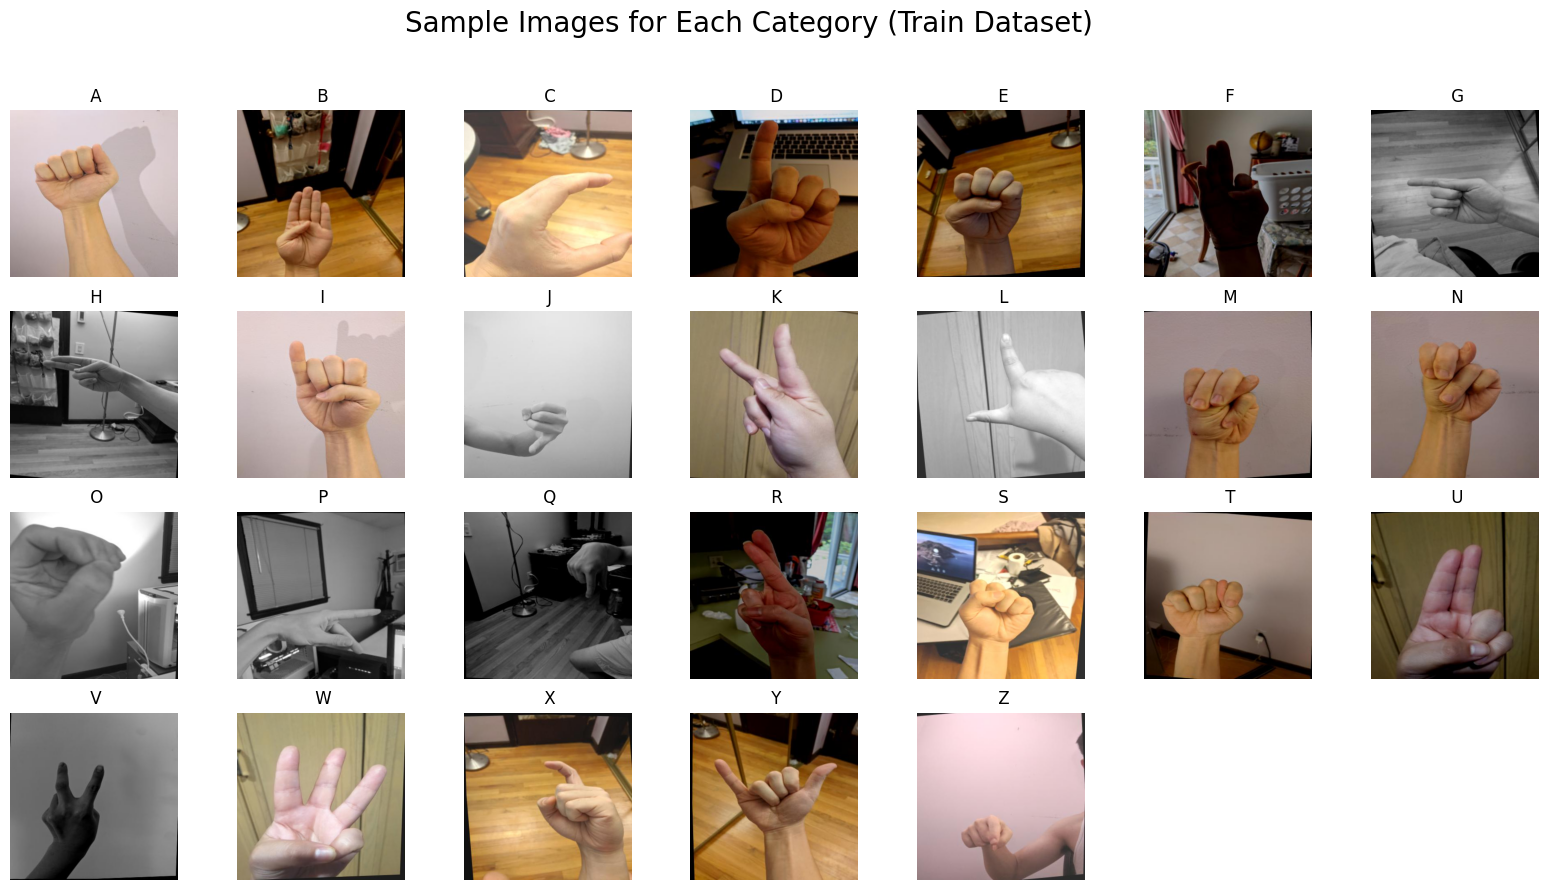

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Function to plot sample images for each alphabet category
def plot_sample_images(df, dataset_path, title):
    # Extract categories from the columns
    categories = df.columns[1:]  # Exclude the file name column
    sample_images = []
    labels = []

    for category in categories:
        # Find one sample for each category
        sample = df[df[category] == 1].iloc[0]
        image_path = os.path.join(dataset_path, sample['filename'])
        sample_images.append(image_path)
        labels.append(category)

    # Plot images
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(sample_images):
        plt.subplot(4, 7, i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(labels[i])
        plt.axis("off")
    plt.suptitle(title, fontsize=20)
    plt.show()

# Call this function for the train dataset
plot_sample_images(
    train_csv,
    "dataset/ASL-Dataset/train",  # Path to the train images
    "Sample Images for Each Category (Train Dataset)"
)


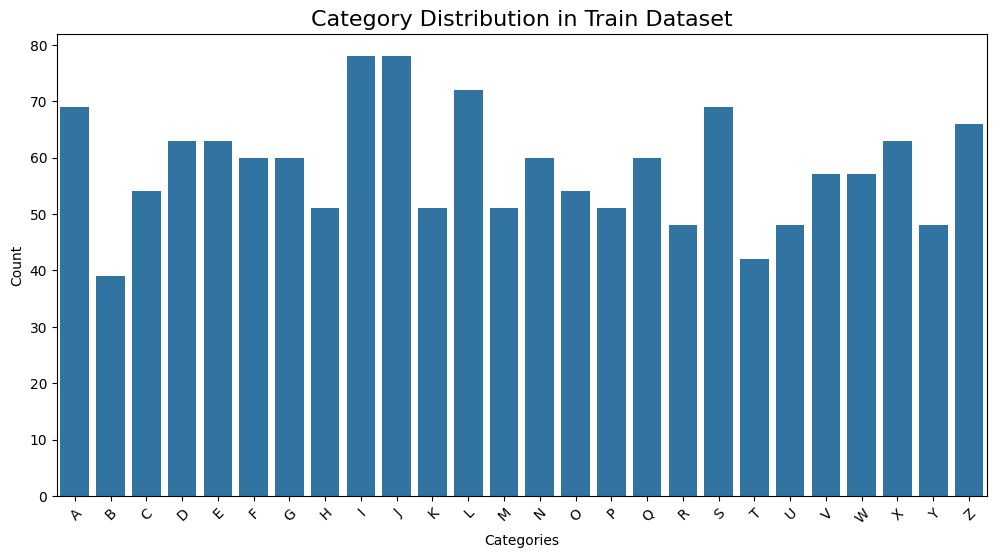

In [ ]:
# Function to check category distribution
def check_imbalances(df, title):
    # Extract categories from the columns
    categories = df.columns[1:]  # Exclude the file name column
    category_counts = df[categories].sum()

    # Plot bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(x=categories, y=category_counts)
    plt.xticks(rotation=45)
    plt.title(title, fontsize=16)
    plt.ylabel("Count")
    plt.xlabel("Categories")
    plt.show()

# Call this function for the train dataset
check_imbalances(train_csv, "Category Distribution in Train Dataset")


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Parameters
IMAGE_SIZE = (128, 128)  # Resize images to 128x128
BATCH_SIZE = 32         # Batch size for training
SEED = 42               # Random seed for reproducibility

# Function to prepare data generators
def prepare_image_generators(train_csv, test_csv, valid_csv, base_path):
    # Add the file path to the CSV data
    def add_file_path(df, folder):
        df['file_path'] = df['filename'].apply(lambda x: os.path.join(base_path, folder, x))
        return df

    train_csv = add_file_path(train_csv, "train")
    test_csv = add_file_path(test_csv, "test")
    valid_csv = add_file_path(valid_csv, "valid")

    # Convert DataFrame to numpy arrays for generators
    def get_image_and_labels(df):
        images = []
        labels = []
        for _, row in df.iterrows():
            # Load and resize image
            img = tf.keras.utils.load_img(row['file_path'], target_size=IMAGE_SIZE)
            img_array = tf.keras.utils.img_to_array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(row[1:].values)  # One-hot encoded labels (excluding filename)
        return np.array(images), np.array(labels)

    train_images, train_labels = get_image_and_labels(train_csv)
    test_images, test_labels = get_image_and_labels(test_csv)
    valid_images, valid_labels = get_image_and_labels(valid_csv)

    return train_images, train_labels, test_images, test_labels, valid_images, valid_labels

# Prepare image arrays and labels
train_images, train_labels, test_images, test_labels, valid_images, valid_labels = prepare_image_generators(
    train_csv, test_csv, valid_csv, "dataset/ASL-Dataset"
)

# Print dataset shapes for verification
print(f"Train Images Shape: {train_images.shape}, Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}, Test Labels Shape: {test_labels.shape}")
print(f"Valid Images Shape: {valid_images.shape}, Valid Labels Shape: {valid_labels.shape}")


Train Images Shape: (1512, 128, 128, 3), Train Labels Shape: (1512, 27)
Test Images Shape: (72, 128, 128, 3), Test Labels Shape: (72, 27)
Valid Images Shape: (144, 128, 128, 3), Valid Labels Shape: (144, 27)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define parameters
NUM_CLASSES = 26  # Number of ASL alphabets
INPUT_SHAPE = (128, 128, 3)  # Image dimensions
EPOCHS = 20
BATCH_SIZE = 32

# Load the MobileNetV2 model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=INPUT_SHAPE)

# Freeze the base model layers
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Summary of the model
#model.summary()

# Set up callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss")

# Train the model
history = model.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint]
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Compile the model again with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Fine-tune the model
history_fine = model.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model
model.save("asl_alphabet_model.h5")


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).